In [1]:
import pandas as pd
from datetime import datetime
import networkx as nx
import itertools
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import copy

import igraph as ig

In [50]:
with open("./graph_networkx_SOUTHAMERICA_msc_route_with_distributions.pkl", 'rb') as f:  # notice the r instead of w
    G_loaded = pickle.load(f)
    G = copy.deepcopy(G_loaded)

### Plot based on longitude, latitude

In [51]:
f = open("data_av/msc_route_country_port_codes.json")
dict_ports = json.load(f)

In [52]:
#Plot nodes based on location
for node, attributes in G.nodes(data=True):
    try:
        attributes["latitude"] = dict_ports[node]["LocationLatitude"]
        attributes["longitude"] = dict_ports[node]["LocationLongitude"]
    except KeyError:
        raise Warning("Port {0} cannot be found".format(node))
        
position_ports = {k: (attr["longitude"], attr["latitude"]) for k, attr in G.nodes(data=True)}

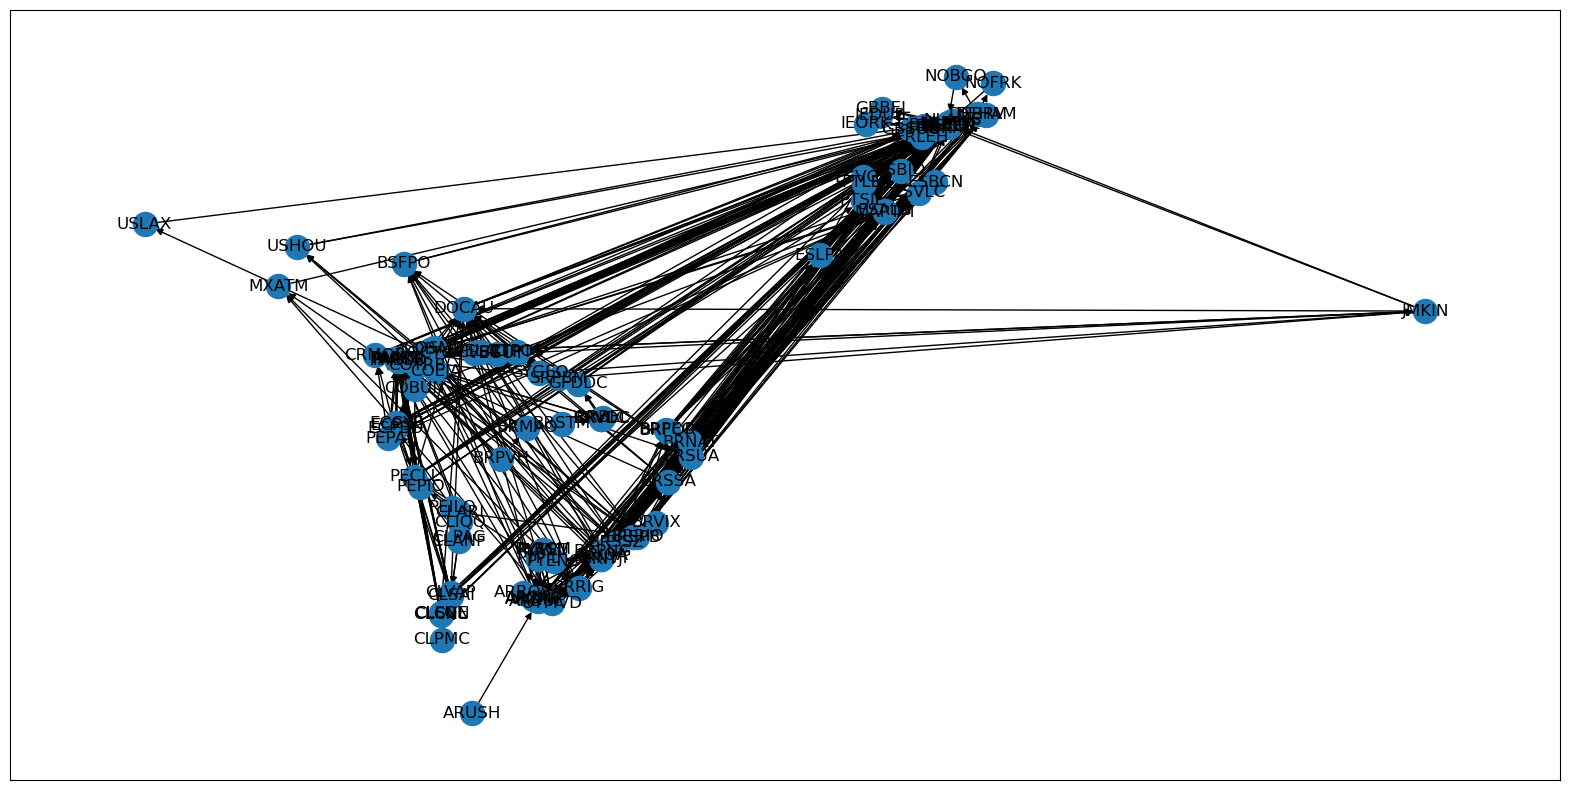

In [53]:
plt.figure(figsize=(20,10))
nx.draw_networkx(G, pos=position_ports)
# plt.savefig("./figure/geo_SA_msc_route.png")

In [54]:
# List of specific nodes
specific_nodes = ["COCTG", "COSMR", "COBAQ", "VELAG", "VEPBL"]

# Initialize an empty subgraph
subgraph = nx.Graph()

# Add specific nodes and their neighbors to the subgraph
for node in specific_nodes:
    ego = nx.ego_graph(G, node, radius=1, center=True)
    subgraph = nx.compose(subgraph, ego)

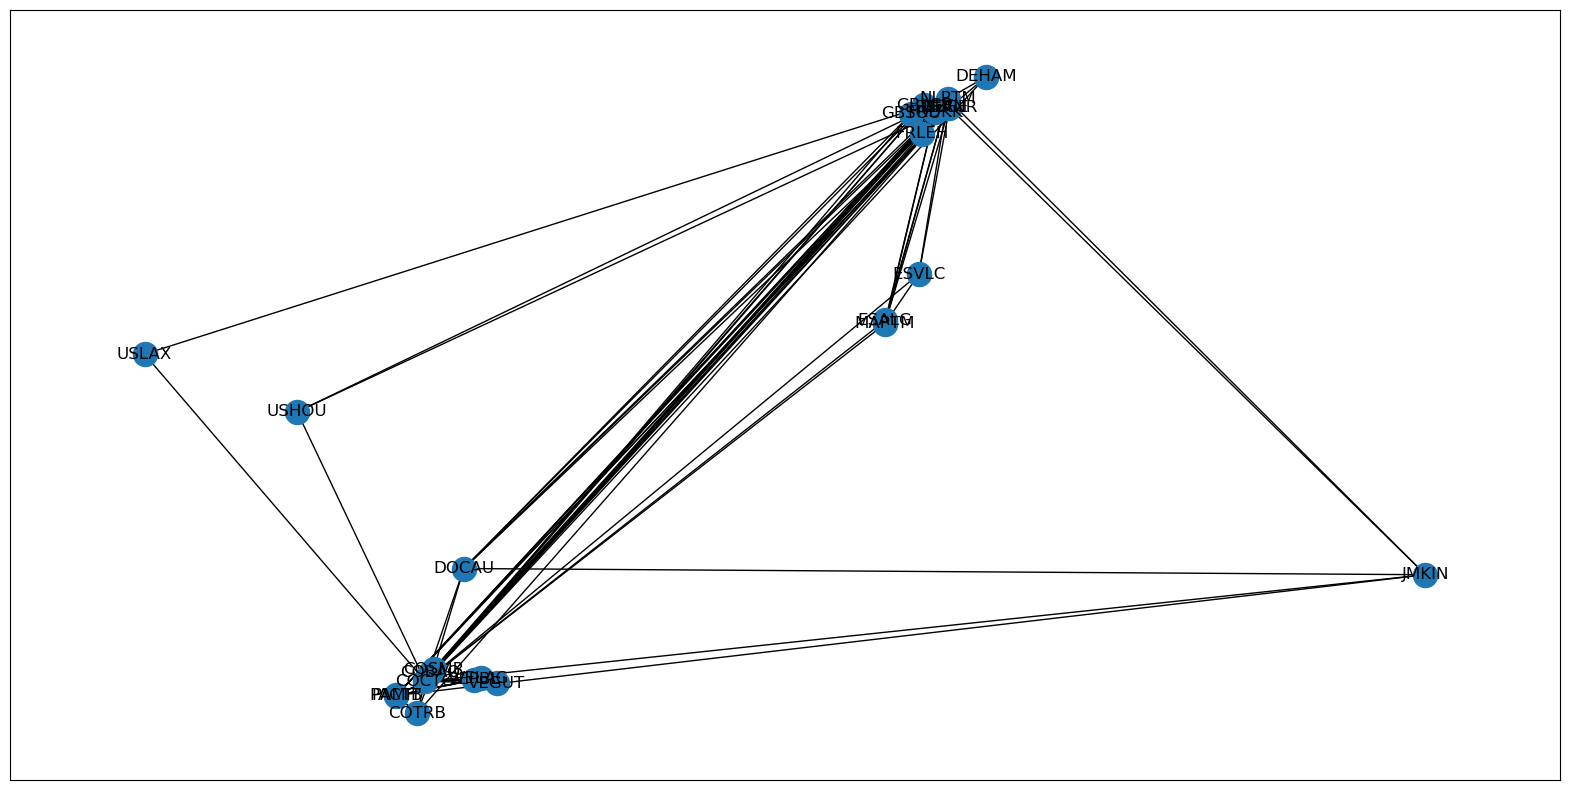

In [55]:
plt.figure(figsize=(20,10))
nx.draw_networkx(subgraph, pos=position_ports)

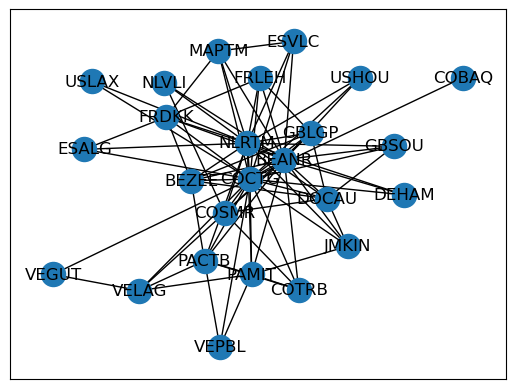

In [56]:
nx.draw_networkx(subgraph)

# Plot with Plotly

In [57]:
import plotly.graph_objects as go

In [58]:
edge_x = []
edge_y = []
for edge in subgraph.edges():
    x0, y0 = (G.nodes[edge[0]]['longitude'], G.nodes[edge[0]]['latitude'])
    x1, y1 = (G.nodes[edge[1]]['longitude'], G.nodes[edge[1]]['latitude'])
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in subgraph.nodes():
    x, y = (G.nodes[node]['longitude'], G.nodes[node]['latitude'])
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [59]:
node_adjacencies = []
node_text = []
for n, attributes in subgraph.nodes(data=True):
    node_text.append(("Port UN Code: "+ str(n) + "\r\n Location: " + "(" + str(attributes["longitude"]) + "," + str(attributes["latitude"]) + ")"))

for node, adjacencies in enumerate(subgraph.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [60]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>International shipping routes: MSC and RouteScanner',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
#                 annotations=[ dict(
#                     text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
#                     showarrow=False,
#                     xref="paper", yref="paper",
#                     x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

## Calculate Betweenness with igraph

In [61]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, Normalize

In [62]:
ig_G = ig.Graph.from_networkx(subgraph)

In [63]:
def plot_betweenness(g, vertex_betweenness, edge_betweenness, ax, cax1, cax2):
    '''Plot vertex/edge betweenness, with colorbars

    Args:
        g: the graph to plot.
        ax: the Axes for the graph
        cax1: the Axes for the vertex betweenness colorbar
        cax2: the Axes for the edge betweenness colorbar
    '''

    # Rescale betweenness to be between 0.0 and 1.0
    scaled_vertex_betweenness = ig.rescale(vertex_betweenness, clamp=True)
    scaled_edge_betweenness = ig.rescale(edge_betweenness, clamp=True)
    print(f"vertices: {min(vertex_betweenness)} - {max(vertex_betweenness)}")
    print(f"edges: {min(edge_betweenness)} - {max(edge_betweenness)}")

    # Define mappings betweenness -> color
    cmap1 = LinearSegmentedColormap.from_list("vertex_cmap", ["pink", "indigo"])
    cmap2 = LinearSegmentedColormap.from_list("edge_cmap", ["lightblue", "midnightblue"])

    # Plot graph
    g.vs["color"] = [cmap1(betweenness) for betweenness in scaled_vertex_betweenness]
    g.vs["size"]  = ig.rescale(vertex_betweenness, (0.1, 0.5))
    g.vs["label"] = ig_G.vs.get_attribute_values('_nx_name')
    g.vs["label_size"] = 8
    g.es["color"] = [cmap2(betweenness) for betweenness in scaled_edge_betweenness]
    g.es["width"] = ig.rescale(edge_betweenness, (0.5, 1.0))
    
    # Set coordinates
    lat = g.vs.get_attribute_values('latitude')
    lon = g.vs.get_attribute_values("longitude")
    
    coords = []
    for la,lo in zip(lat, lon):
        c = (lo, la)
        coords.append(c)
        
    ig.plot(
        g,
        target=ax,
        layout="fruchterman_reingold", #coords
        vertex_frame_width=0.2,
    )

    # Color bars
    norm1 = ScalarMappable(norm=Normalize(0, max(vertex_betweenness)), cmap=cmap1)
    norm2 = ScalarMappable(norm=Normalize(0, max(edge_betweenness)), cmap=cmap2)
    plt.colorbar(norm1, cax=cax1, orientation="horizontal", label='Vertex Betweenness')
    plt.colorbar(norm2, cax=cax2, orientation="horizontal", label='Edge Betweenness')

Calculate betweenness without weights

In [64]:
#Unweighted shortest path now! 
vertex_betweenness1 = ig_G.betweenness()
edge_betweenness1 = ig_G.edge_betweenness()

In [65]:
centrality_df = pd.DataFrame(list(zip(ig_G.vs.get_attribute_values('_nx_name'), vertex_betweenness1, edge_betweenness1, ig_G.degree(mode="in"), 
                                      ig_G.degree(mode="out"), ig_G.degree(mode="all"), ig_G.closeness())),
              columns=['port',"betweenness", "edge_betweenness",'in_degree', 'out_degree', "sum_of_degrees", "closeness"])

In [66]:
centrality_df

,port,betweenness,edge_betweenness,in_degree,out_degree,sum_of_degrees,closeness
0,ESALG,0.000000,8.833333,3,3,3,0.533333
1,BEANR,36.128571,2.333333,18,18,18,0.800000
2,ESVLC,0.000000,12.833333,4,4,4,0.545455
3,USLAX,0.000000,2.033333,2,2,2,0.521739
4,PAMIT,4.152381,5.283333,8,8,8,0.600000
5,JMKIN,0.250000,4.233333,5,5,5,0.558140
6,USHOU,0.000000,5.916667,3,3,3,0.533333
7,DOCAU,1.950000,5.592857,8,8,8,0.600000
8,MAPTM,0.250000,5.083333,5,5,5,0.558140
9,PACTB,4.152381,6.333333,8,8,8,0.600000


vertices: 0.0 - 113.21190476190476
edges: 1.25 - 24.0


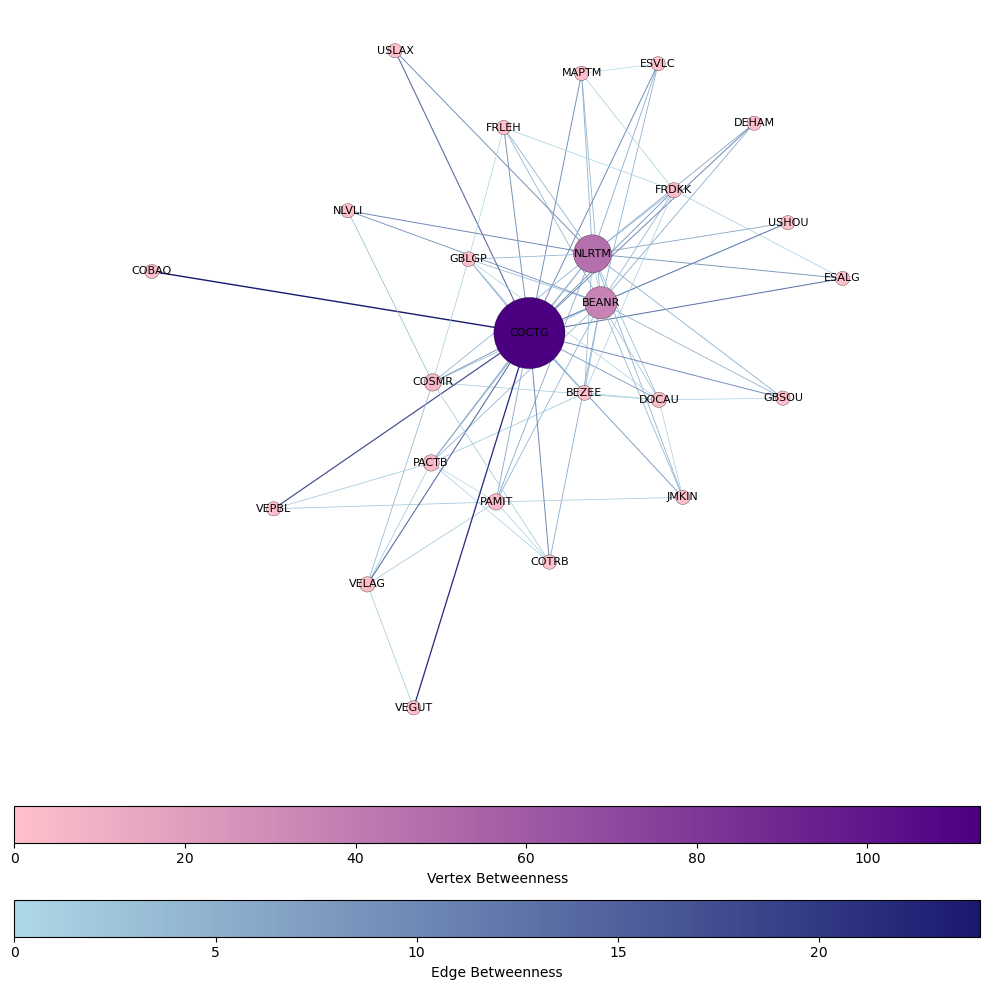

In [67]:
fig, axs = plt.subplots(
    3, 1,
    figsize=(10, 10),
    gridspec_kw=dict(height_ratios=(20, 1, 1)),
)
plot_betweenness(ig_G, vertex_betweenness1, edge_betweenness1, *axs)
#plot_betweenness(ig_G, vertex_betweenness1, edge_betweenness1, *axs[:, 1])
fig.tight_layout(h_pad=1)
# plt.savefig("./figure/betweenness_SA_msc_route.png")
plt.show()

Calculate betweenness with weights

In [68]:
#Centrality with weights
vertex_betweenness_weights = ig_G.betweenness(weights="median_time_minutes")
edge_betweenness_weights = ig_G.edge_betweenness(weights="median_time_minutes")

centrality_df_weights = pd.DataFrame(list(zip(ig_G.vs.get_attribute_values('_nx_name'), vertex_betweenness_weights, edge_betweenness_weights, ig_G.degree(mode="in"), 
                                      ig_G.degree(mode="out"), ig_G.degree(mode="all"), ig_G.closeness())),
              columns=['port',"betweenness", "edge_betweenness",'in_degree', 'out_degree', "sum_of_degrees", "closeness"])

In [69]:
centrality_df_weights

,port,betweenness,edge_betweenness,in_degree,out_degree,sum_of_degrees,closeness
0,ESALG,0.0,0.0,3,3,3,0.533333
1,BEANR,50.0,13.0,18,18,18,0.800000
2,ESVLC,0.0,11.0,4,4,4,0.545455
3,USLAX,0.0,8.0,2,2,2,0.521739
4,PAMIT,52.0,16.0,8,8,8,0.600000
5,JMKIN,0.0,41.0,5,5,5,0.558140
6,USHOU,0.0,0.0,3,3,3,0.533333
7,DOCAU,90.0,0.0,8,8,8,0.600000
8,MAPTM,23.0,0.0,5,5,5,0.558140
9,PACTB,12.0,12.0,8,8,8,0.600000


vertices: 0.0 - 115.0
edges: 0.0 - 99.0


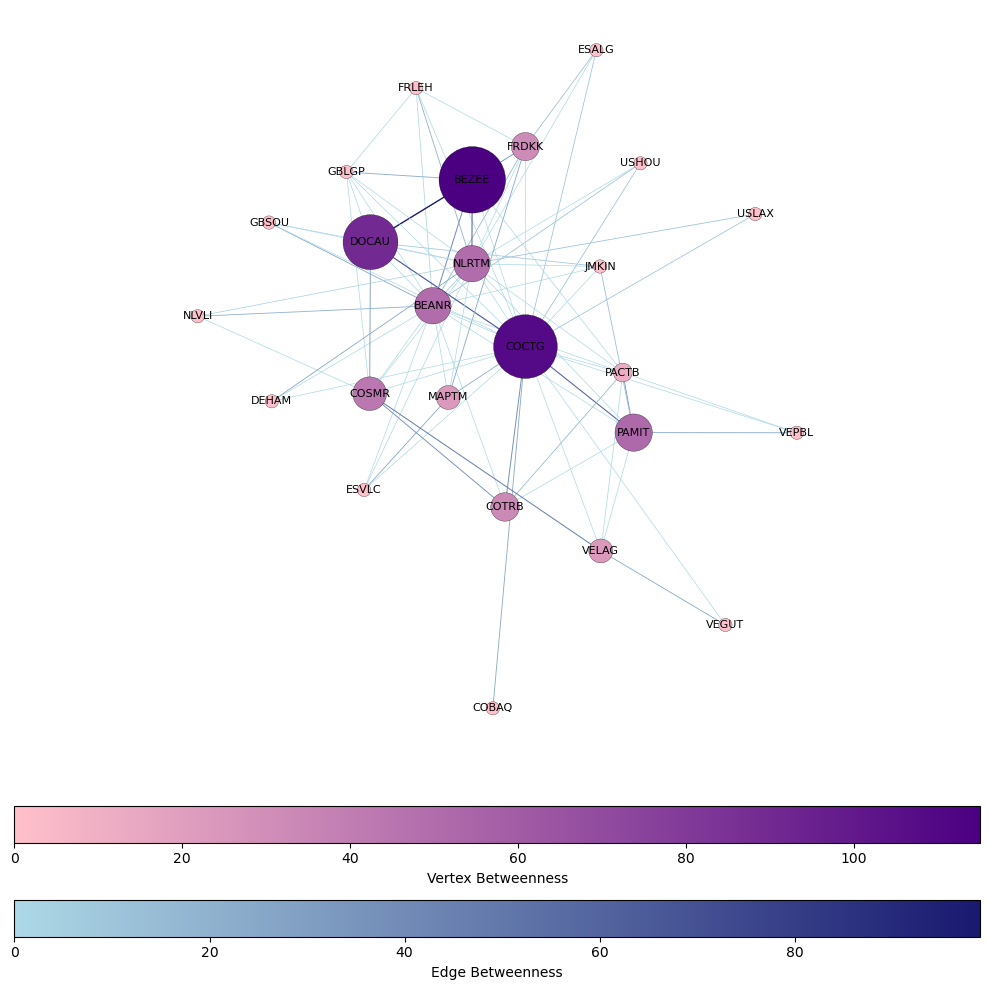

In [70]:
fig, axs = plt.subplots(
    3, 1,
    figsize=(10, 10),
    gridspec_kw=dict(height_ratios=(20, 1, 1)),
)
plot_betweenness(ig_G, vertex_betweenness_weights, edge_betweenness_weights, *axs)
fig.tight_layout(h_pad=1)
# plt.savefig("./figure/betweenness_weights_SA_msc_route.png")
plt.show()

Plot degree

In [71]:
def plot_degree(g, degree, title, ax, cax1):
    '''Plot degree

    Args:
        g: the graph to plot.
        ax: the Axes for the graph
        cax1: the Axes for the degree colorbar
    '''

    # Rescale degree to be between 0.0 and 1.0
    scaled_degree = ig.rescale(degree, clamp=True)
    print(f"degree: {min(in_degree)} - {max(in_degree)}")

    # Define mappings betweenness -> color
    cmap1 = LinearSegmentedColormap.from_list("degree_cmap", ["pink", "indigo"])
    
    # Plot graph
    g.vs["color"] = [cmap1(degree) for degree in scaled_degree]
    g.vs["size"]  = ig.rescale(degree, (0.1, 0.5))
    g.vs["label"] = ig_G.vs.get_attribute_values('_nx_name')
    g.vs["label_size"] = 8
    
    ig.plot(
        g,
        target=ax,
        layout="fruchterman_reingold", #coords 
        vertex_frame_width=0.2,
    )
    
    ax.set_title(title)

    # Color bars
    norm1 = ScalarMappable(norm=Normalize(0, max(degree)), cmap=cmap1)
    plt.colorbar(norm1, cax=cax1, orientation="horizontal", label='Degree', shrink=0.5)

In [72]:
in_degree = ig_G.degree(mode="in")
out_degree = ig_G.degree(mode="out")

degree: 1 - 23
degree: 1 - 23


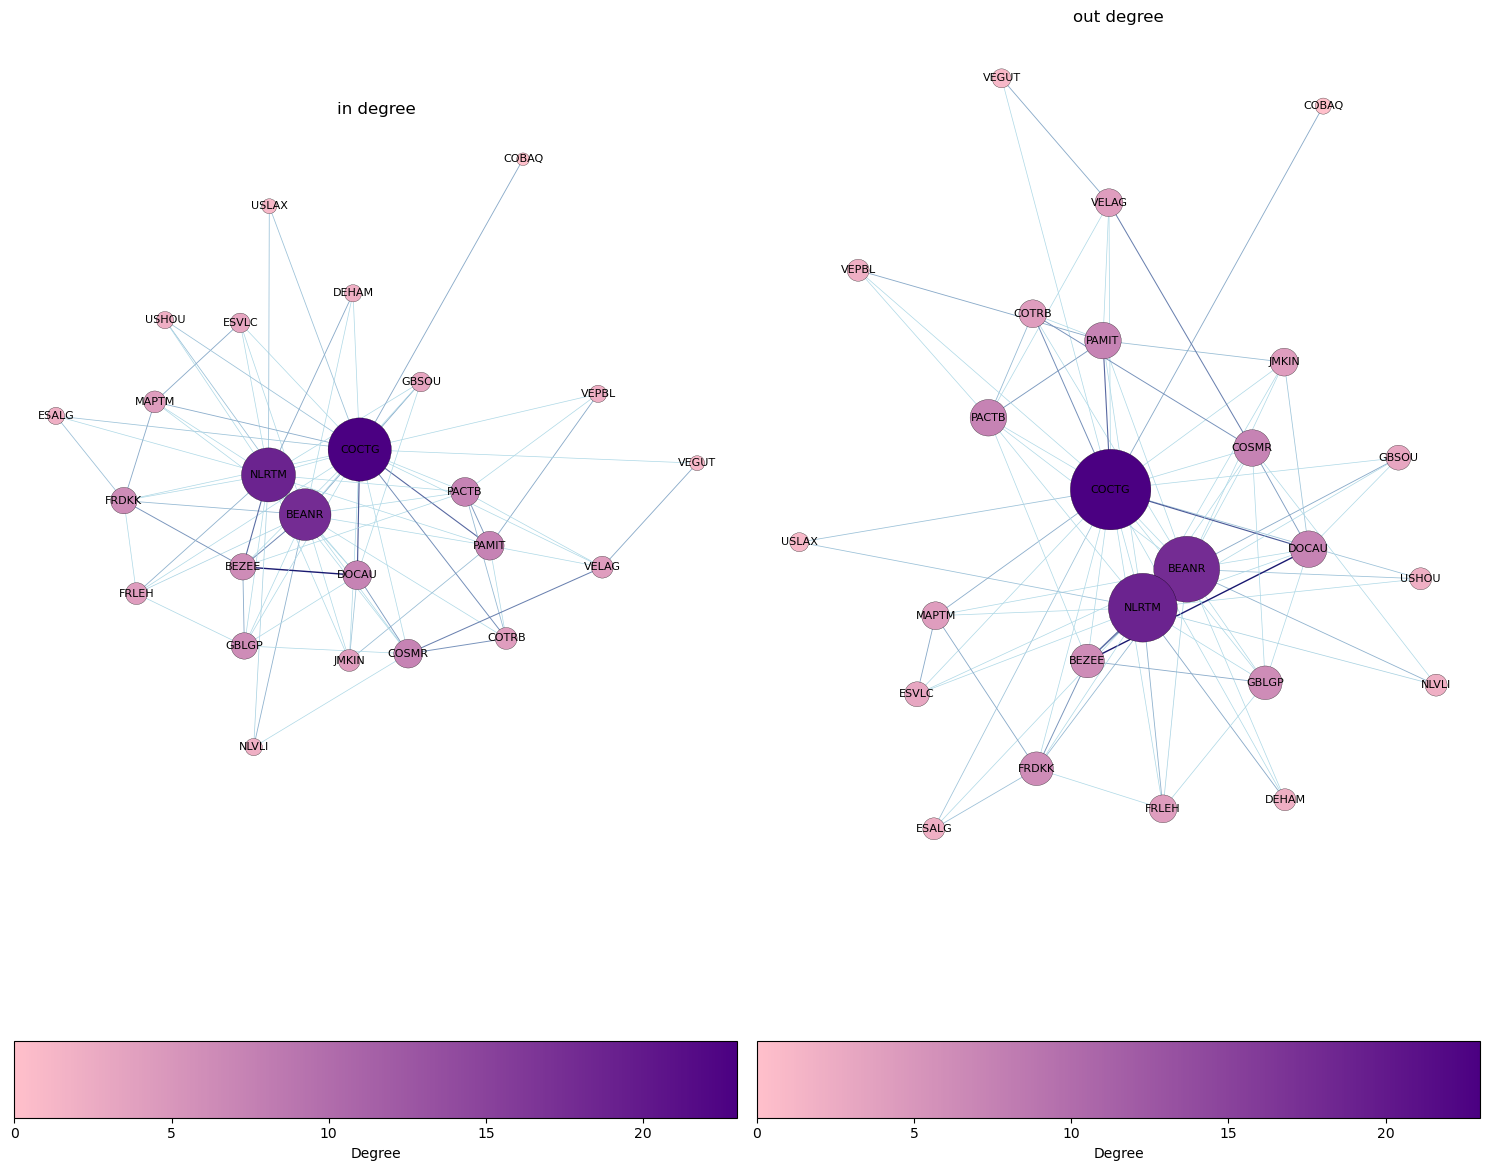

In [73]:
fig, axs = plt.subplots(
    2, 2,
    figsize=(15, 15),
    gridspec_kw=dict(height_ratios=(20, 1)),
)

plot_degree(ig_G, in_degree, "in degree", *axs[:, 0])
plot_degree(ig_G, out_degree, "out degree", *axs[:, 1])
fig.tight_layout(h_pad=1)
# plt.savefig("./figure/degree_SA_msc_route.png")
plt.show()